In [1]:
import copy
import itertools
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# set path to datasets
PATH_TO_RPKM_DATA = "./data/CCLE_RNAseq_genes_rpkm_20180929.gct"
PATH_TO_ANTICANCER_DRUG_DATA = "./data/CCLE_NP24.2009_Drug_data_2015.02.24.csv"

In [3]:
# reading RPKM data
# first two rows and first two columns are irrelevant
# index_col can be used to set the row names
RPKMData = pd.read_csv(PATH_TO_RPKM_DATA, sep = '\t', skiprows = 2, index_col = 0)

drugData = pd.read_csv(PATH_TO_ANTICANCER_DRUG_DATA, delimiter=',')

In [4]:
# identifying compounds in dataset
allCompounds = drugData['Compound'].unique()
print(allCompounds)

# separate data by compound 
drugDataByCompound = {compound : drugData.loc[drugData['Compound'] == compound] for compound in allCompounds}
print(drugDataByCompound[allCompounds[0]])

['AEW541' 'Nilotinib' '17-AAG' 'PHA-665752' 'Lapatinib' 'Nutlin-3'
 'AZD0530' 'PF2341066' 'L-685458' 'ZD-6474' 'Panobinostat' 'Sorafenib'
 'Irinotecan' 'Topotecan' 'LBW242' 'PD-0325901' 'PD-0332991' 'Paclitaxel'
 'AZD6244' 'PLX4720' 'RAF265' 'TAE684' 'TKI258' 'Erlotinib']
               CCLE Cell Line Name Primary Cell Line Name Compound Target  \
0    1321N1_CENTRAL_NERVOUS_SYSTEM                 1321N1   AEW541  IGF1R   
1                   22RV1_PROSTATE                  22Rv1   AEW541  IGF1R   
2    42MGBA_CENTRAL_NERVOUS_SYSTEM               42-MG-BA   AEW541  IGF1R   
3               5637_URINARY_TRACT                   5637   AEW541  IGF1R   
4               639V_URINARY_TRACT                  639-V   AEW541  IGF1R   
..                             ...                    ...      ...    ...   
498                      WM88_SKIN                  WM-88   AEW541  IGF1R   
499                    WM983B_SKIN                WM-983B   AEW541  IGF1R   
500    YKG1_CENTRAL_NERVOUS_SYSTEM

In [5]:
# sort data per compound by IC50
for compound in allCompounds:
    sortData = copy.deepcopy(drugDataByCompound[compound])
    sortData.sort_values(by = ['IC50 (uM)'], inplace = True)
    drugDataByCompound[compound] = sortData
print(drugDataByCompound[allCompounds[0]])

                            CCLE Cell Line Name Primary Cell Line Name  \
321                               NCIH2122_LUNG              NCI-H2122   
170                                  IGR37_SKIN                 IGR-37   
428                     SKNFI_AUTONOMIC_GANGLIA                SK-N-FI   
444  SUDHL10_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE              SU-DHL-10   
21      AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE                  AMO-1   
..                                          ...                    ...   
231                           KYSE30_OESOPHAGUS                KYSE-30   
229                          KYSE150_OESOPHAGUS               KYSE-150   
227                            KYM1_SOFT_TISSUE                  KYM-1   
222                                KP3_PANCREAS                   KP-3   
502                               ZR7530_BREAST               ZR-75-30   

    Compound Target                            Doses (uM)  \
321   AEW541  IGF1R  .0025,.0080,.025,.080,.25,.80

[]

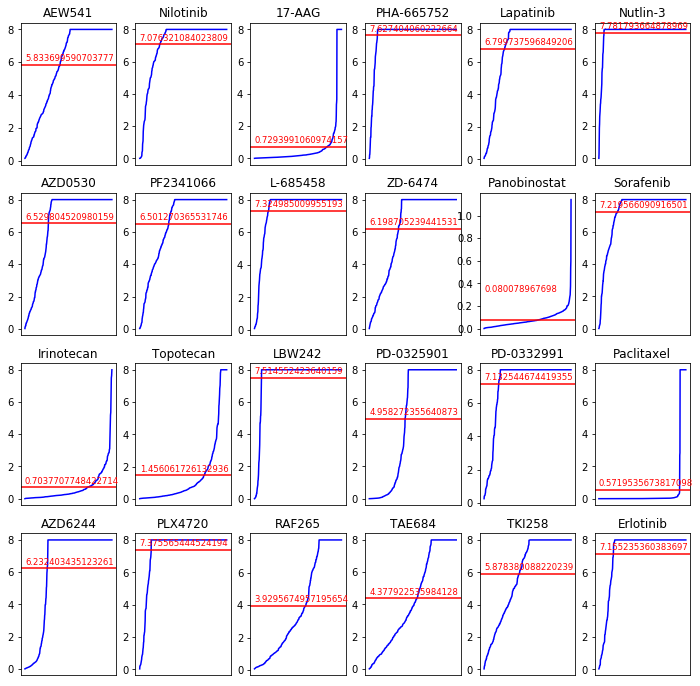

In [6]:
fig, axes = plt.subplots(4, 6, figsize = (12, 12))
fig.set_facecolor('w')
for i in range(4):
    for j in range(6):
        compound = allCompounds[i*6 + j]
        axes[i, j].plot(drugDataByCompound[compound]['CCLE Cell Line Name'], drugDataByCompound[compound]['IC50 (uM)'], color = 'b')
        axes[i, j].axhline(y = drugDataByCompound[compound]['IC50 (uM)'].mean(), color = 'r')
        axes[i, j].text(0, drugDataByCompound[compound]['IC50 (uM)'].mean() + 0.25, str(drugDataByCompound[compound]['IC50 (uM)'].mean()), color = 'r', fontsize = 8.5)
        axes[i, j].set_title(compound)
plt.setp(plt.gcf().get_axes(), xticks=[])

In [7]:
# extract IC50 data for a given compound
# compound = 'AEW541' # 0.58
# compound = 'AZD6244' # 0.80
# compound = 'TAE684'
# compound = 'TKI258' # 0.56
compound = 'PD-0325901' # 0.73
# compound = 'PF2341066' # 0.73
# compound = 'Topotecan' # 0.75
# compound = 'ZD-6474' # 0.65
ic50 = pd.Series(list(drugDataByCompound[compound]['IC50 (uM)']), index = list(drugDataByCompound[compound]['CCLE Cell Line Name']))
print(ic50)

OCIAML2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    0.002500
SIGM5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      0.002543
WM88_SKIN                                     0.003395
MALME3M_SKIN                                  0.004155
KO52_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       0.004738
                                                ...   
KNS60_CENTRAL_NERVOUS_SYSTEM                  8.000000
KNS42_CENTRAL_NERVOUS_SYSTEM                  8.000000
KMS34_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      8.000000
KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    8.000000
ZR7530_BREAST                                 8.000000
Length: 504, dtype: float64


In [8]:
# limit data to samples with IC50 data and RPKM data
all_samples = list(set(RPKMData.columns) & set(ic50.index))
ic50 = ic50[all_samples]
print(ic50)

MC116_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    8.000000
UACC257_SKIN                                0.019956
YKG1_CENTRAL_NERVOUS_SYSTEM                 8.000000
SUIT2_PANCREAS                              0.168788
MFE319_ENDOMETRIUM                          2.332026
                                              ...   
NCIH1666_LUNG                               0.028687
WM1799_SKIN                                 0.036501
HEC151_ENDOMETRIUM                          0.081983
SF126_CENTRAL_NERVOUS_SYSTEM                6.895612
LS123_LARGE_INTESTINE                       8.000000
Length: 469, dtype: float64


In [12]:
RPKMData.columns

Index(['Description', '22RV1_PROSTATE', '2313287_STOMACH',
       '253JBV_URINARY_TRACT', '253J_URINARY_TRACT',
       '42MGBA_CENTRAL_NERVOUS_SYSTEM', '5637_URINARY_TRACT', '59M_OVARY',
       '639V_URINARY_TRACT', '647V_URINARY_TRACT',
       ...
       'WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'YAPC_PANCREAS',
       'YD10B_UPPER_AERODIGESTIVE_TRACT', 'YD15_SALIVARY_GLAND',
       'YD38_UPPER_AERODIGESTIVE_TRACT', 'YD8_UPPER_AERODIGESTIVE_TRACT',
       'YH13_CENTRAL_NERVOUS_SYSTEM', 'YKG1_CENTRAL_NERVOUS_SYSTEM',
       'ZR751_BREAST', 'ZR7530_BREAST'],
      dtype='object', length=1020)

In [9]:
# convert IC50 data into resistant/sensitive labels based on mean()
drug_response = pd.Series(['Resistant' if item > ic50.mean() else 'Sensitive' for i, item in ic50.iteritems()], index = ic50.index)
print(drug_response)

MC116_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    Resistant
UACC257_SKIN                                Sensitive
YKG1_CENTRAL_NERVOUS_SYSTEM                 Resistant
SUIT2_PANCREAS                              Sensitive
MFE319_ENDOMETRIUM                          Sensitive
                                              ...    
NCIH1666_LUNG                               Sensitive
WM1799_SKIN                                 Sensitive
HEC151_ENDOMETRIUM                          Sensitive
SF126_CENTRAL_NERVOUS_SYSTEM                Resistant
LS123_LARGE_INTESTINE                       Resistant
Length: 469, dtype: object


In [10]:
# apply a variance based feature reduction (removing bottom 40% lowest variance)
filtered_RPKMData = RPKMData[all_samples]
filtered_RPKMData = filtered_RPKMData[filtered_RPKMData.var(axis = 1) > RPKMData[all_samples].var(axis = 1).quantile(q = 0.4)]

## evaluate adding tumor type as a feature
unique_tumor_types = set(['_'.join(sample.split('_')[1:]) for sample in all_samples])
encoding_map = {tumor_type : index for index, tumor_type in enumerate(unique_tumor_types)}
tumor_type_df = pd.DataFrame({'TumorType' : {sample : encoding_map['_'.join(sample.split('_')[1:])] for sample in all_samples}}).transpose()
filtered_withtype_RPKMData = pd.concat([filtered_RPKMData, tumor_type_df])

C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [11]:
# randomly assign samples to bins
sample_bins = {}
n_bins = 30
random_seed = 1234
drug_response = drug_response.sample(frac = 1, random_state = random_seed)
for i, sample in enumerate(drug_response.index):
    sample_bins.setdefault(i%n_bins,[]).append(sample)

In [12]:
# unfiltered data
total_correct = 0
total_tested = 0
for test_bin in range(n_bins):
    train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
    test_samples = sample_bins[test_bin]
    train_labels = drug_response[train_samples]
    train_RPKM = RPKMData[train_samples].transpose()
    test_labels = drug_response[test_samples]
    test_RPKM = RPKMData[test_samples].transpose()

    train_rf = RandomForestClassifier(n_estimators = 1000, random_state = random_seed)
    train_rf.fit(train_RPKM, train_labels)
    test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

    total_correct += sum(test_predictions == test_labels)
    total_tested += len(test_predictions)

print(total_correct/total_tested)

0.7185501066098081


In [13]:
# with filtered data
total_correct = 0
total_tested = 0
for test_bin in range(n_bins):
    train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
    test_samples = sample_bins[test_bin]
    train_labels = drug_response[train_samples]
    train_RPKM = filtered_RPKMData[train_samples].transpose()
    test_labels = drug_response[test_samples]
    test_RPKM = filtered_RPKMData[test_samples].transpose()

    train_rf = RandomForestClassifier(n_estimators = 1000, random_state = random_seed)
    train_rf.fit(train_RPKM, train_labels)
    test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

    total_correct += sum(test_predictions == test_labels)
    total_tested += len(test_predictions)

print(total_correct/total_tested)

0.7334754797441365


In [14]:
# filtered data with tumor type as feature
total_correct = 0
total_tested = 0
for test_bin in range(n_bins):
    train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
    test_samples = sample_bins[test_bin]
    train_labels = drug_response[train_samples]
    train_RPKM = filtered_withtype_RPKMData[train_samples].transpose()
    test_labels = drug_response[test_samples]
    test_RPKM = filtered_withtype_RPKMData[test_samples].transpose()

    train_rf = RandomForestClassifier(n_estimators = 1000, random_state = random_seed)
    train_rf.fit(train_RPKM, train_labels)
    test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

    total_correct += sum(test_predictions == test_labels)
    total_tested += len(test_predictions)

print(total_correct/total_tested)

0.7420042643923241


In [15]:
# STEP 1: impute missing data with k nearest neighbors
for train_bins_count in [1, 2, 5, 10, 20, 29]:
    total_correct = 0
    total_tested = 0
    bin_interval = min(train_bins_count, n_bins - train_bins_count)
    for current_interval in range(int(n_bins/bin_interval)):
        if train_bins_count == bin_interval:
            train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
            test_samples = list(itertools.chain.from_iterable([sample_bins[i] if i not in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
        else:
            train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i not in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
            test_samples = list(itertools.chain.from_iterable([sample_bins[i] if i in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
        # STEP 2: add a step to remove any imputed samples from test_samples
        train_labels = drug_response[train_samples]
        train_RPKM = filtered_RPKMData[train_samples].transpose()
        test_labels = drug_response[test_samples]
        test_RPKM = filtered_RPKMData[test_samples].transpose()

        train_rf = RandomForestClassifier(n_estimators = 1000, random_state = random_seed)
        train_rf.fit(train_RPKM, train_labels)
        test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

        total_correct += sum(test_predictions == test_labels)
        total_tested += len(test_predictions)
    print((train_bins_count, total_correct/total_tested))
    
# next steps here, impute labels for samples in RNAseq dataset without labels then see the effect of using those data points for training
# (include this data in the randomization of binning, and use this data to train the model, but don't use this data in the calculation of accuracy)

(1, 0.5753988677303139)
(2, 0.6040207127627171)
(5, 0.664818763326226)
(10, 0.7046908315565032)
(20, 0.7313432835820896)
(29, 0.7334754797441365)


In [16]:
# # set up training and testing datasets
# test_bin = 0 # iterate
# train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
# train_labels = drug_response[train_samples]
# train_RPKM = RPKMData[train_samples].transpose()

# test_samples = sample_bins[test_bin]
# test_labels = drug_response[test_samples]
# test_RPKM = RPKMData[test_samples].transpose()

# # copy train samples
# # for loop and crop out left of first instance of '_'
# # append to the training dataframe
# cancer_train_samples = train_samples
# for i in range(len(cancer_train_samples)):
#     cancer_type = cancer_train_samples[i][cancer_train_samples[i].find('_') + 1:]
#     cancer_train_samples[i] = cancer_types_map.index(cancer_type)
# train_RPKM["Cancer"] = cancer_train_samples

# cancer_test_samples = test_samples
# for i in range(len(cancer_test_samples)):
#     cancer_type = cancer_test_samples[i][cancer_test_samples[i].find('_') + 1:]
#     cancer_test_samples[i] = cancer_types_map.index(cancer_type)
# test_RPKM["Cancer"] = cancer_test_samples

# # model
# train_rf = RandomForestClassifier(n_estimators = 256, random_state = random_seed)
# train_rf.fit(train_RPKM, train_labels)
# test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

# # compares predictions against actual labels to get accuracy
# print(sum(test_predictions == test_labels)/len(test_predictions))

In [111]:
total_feature_importances = pd.DataFrame(np.zeros((len(filtered_RPKMData), 1))).squeeze()
total_feature_importances = total_feature_importances.reindex(list(feature_importances.index), fill_value = 0)
for i in range(5):
    print(i)
    bin_interval = min(29, n_bins - 29)
    for current_interval in range(int(n_bins/bin_interval)):
        if train_bins_count == bin_interval:
            train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
        else:
            train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i not in range(current_interval*bin_interval, (current_interval + 1)*bin_interval) else [] for i in sample_bins.keys()]))
        # add a step to remove any imputed samples from the test array
        
        train_rf = RandomForestClassifier(n_estimators = 1000, random_state = random_seed)
        train_rf.fit(filtered_RPKMData[train_samples].transpose(), drug_response[train_samples])
        feature_importances = pd.Series(train_rf.feature_importances_, index = train_RPKM.columns)
        total_feature_importances += feature_importances
            
total_feature_importances

0
1
2
3
4


ENSG00000223972.4    0.002064
ENSG00000227232.4    0.002998
ENSG00000238009.2    0.010384
ENSG00000233750.3    0.003452
ENSG00000237683.5    0.003970
                       ...   
ENSG00000198695.2    0.006371
ENSG00000210194.1    0.003073
ENSG00000198727.2    0.003182
ENSG00000210195.2    0.002363
ENSG00000210196.2    0.003261
Name: 0, Length: 33721, dtype: float64

In [191]:
feature_importances = total_feature_importances.div(5)
feature_importances.to_csv('./data/final_feature_importances')
save = pd.read_csv('./data/final_feature_importances', header = None)

C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [192]:
save

,0,1
0,ENSG00000223972.4,0.000413
1,ENSG00000227232.4,0.000600
2,ENSG00000238009.2,0.002077
3,ENSG00000233750.3,0.000690
4,ENSG00000237683.5,0.000794
...,...,...
33716,ENSG00000198695.2,0.001274
33717,ENSG00000210194.1,0.000615
33718,ENSG00000198727.2,0.000636
33719,ENSG00000210195.2,0.000473


In [123]:
importance_RPKMData = filtered_RPKMData[all_samples][feature_importances > feature_importances[feature_importances > 0.0].quantile(0.995)]
importance_RPKMData = importance_RPKMData.sub(importance_RPKMData.mean(axis = 1), axis = 0)
importance_RPKMData = importance_RPKMData.divide(importance_RPKMData.var(axis = 1)**(1/2), axis = 0)
importance_RPKMData

,NCIH1915_LUNG,HS683_CENTRAL_NERVOUS_SYSTEM,WM2664_SKIN,KP2_PANCREAS,SNU423_LIVER,SW1417_LARGE_INTESTINE,SNU398_LIVER,COLO678_LARGE_INTESTINE,NCIH211_LUNG,BXPC3_PANCREAS,...,SKNDZ_AUTONOMIC_GANGLIA,HS936T_SKIN,A172_CENTRAL_NERVOUS_SYSTEM,TOV112D_OVARY,SNU387_LIVER,QGP1_PANCREAS,OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HPAC_PANCREAS,SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KP4_PANCREAS
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000238164.2,-0.362970,-0.324804,0.672442,0.254807,-0.411061,1.274377,-0.426065,0.249897,-0.429653,0.081643,...,-0.432995,2.108179,-0.429981,-0.419887,-0.335541,-0.358539,-0.261738,-0.381131,0.965392,-0.415429
ENSG00000160062.10,-0.356289,-0.100184,0.717846,-0.254955,-0.393978,-0.387666,-0.174667,-0.209545,-0.161202,-0.506139,...,0.875905,-0.230753,-0.188032,0.648558,-0.160248,0.182427,0.094356,0.359696,-0.155103,0.156987
ENSG00000117016.5,-0.323869,-0.290400,-0.299592,-0.202913,-0.324259,-0.244543,-0.156739,-0.158808,-0.135705,-0.331014,...,4.891468,-0.189907,-0.146365,0.081357,-0.335080,0.004267,-0.261270,-0.332770,0.266810,0.012308
ENSG00000171790.11,5.717448,-0.215287,-0.209787,-0.500779,-0.401811,-0.386498,0.306159,0.133320,0.326485,-0.609336,...,-0.428591,-0.522093,-0.378450,0.078836,-0.230953,-0.180858,0.534396,-0.123838,0.509085,0.110610
ENSG00000123080.6,-0.187689,1.565831,0.991953,-0.171661,-0.006342,-0.705333,1.567732,-0.296838,-0.377047,-0.617527,...,0.862728,-0.167408,0.608133,-0.569822,0.940486,-0.539327,-0.912676,-0.778322,-0.913633,-0.679349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000234622.1,-0.332414,-0.002133,-0.332414,-0.332414,7.407250,-0.226759,-0.332414,-0.332414,-0.332414,-0.332414,...,-0.332414,-0.258508,0.642737,-0.332414,-0.165454,-0.332414,-0.332414,-0.332414,-0.332414,-0.332414
ENSG00000188021.7,-1.281527,0.554939,-0.421750,0.215552,1.485522,-0.487915,-0.396069,0.826154,-0.062701,-0.116795,...,1.897801,-0.164871,0.476443,2.361476,0.552241,0.719625,0.546690,-1.239498,-0.473873,2.479989
ENSG00000169562.9,-0.290978,-0.291588,2.638298,-0.285753,-0.291447,0.488151,-0.290021,-0.290010,-0.290483,-0.273823,...,-0.289277,5.987212,-0.291257,-0.292104,-0.290364,0.848032,-0.291195,-0.291599,-0.290899,-0.291534


In [124]:
sensitive_samples = list(drug_response[drug_response == 'Sensitive'].index)
resistant_samples = list(drug_response[drug_response == 'Resistant'].index)
max(importance_RPKMData[sensitive_samples + resistant_samples].max())

19.1238115923028

In [176]:
cmap_gene = sns.diverging_palette(127.7, 12.2, s = 99.9, l = 50, n = 9, center = "dark", as_cmap = True)

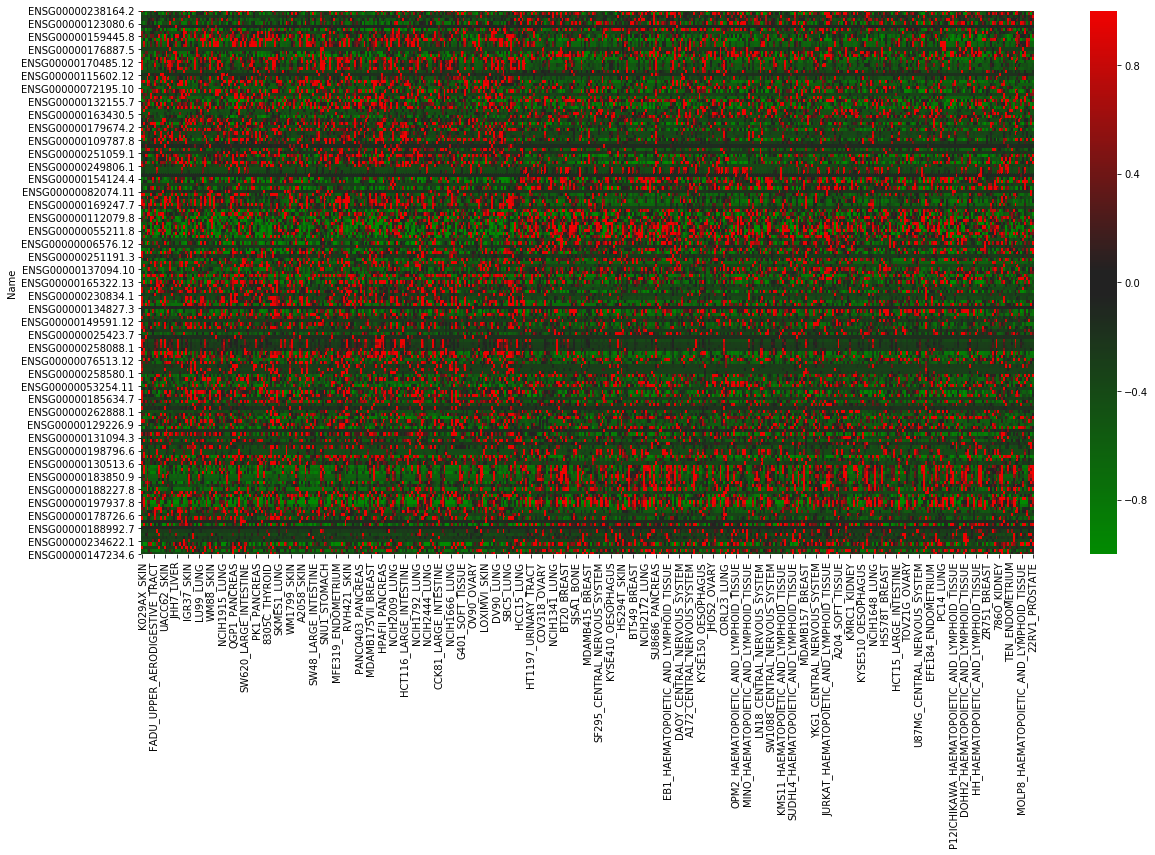

In [173]:
plt.figure(figsize = (20,10))
sns.heatmap(importance_RPKMData[sensitive_samples + resistant_samples], cmap = cmap_gene, vmin = -1.0, vmax = 1.0)
# two things we want to try, (1) sort samples by increasing IC50 + add color bar for tissuetype and (2) group samples by tissue type

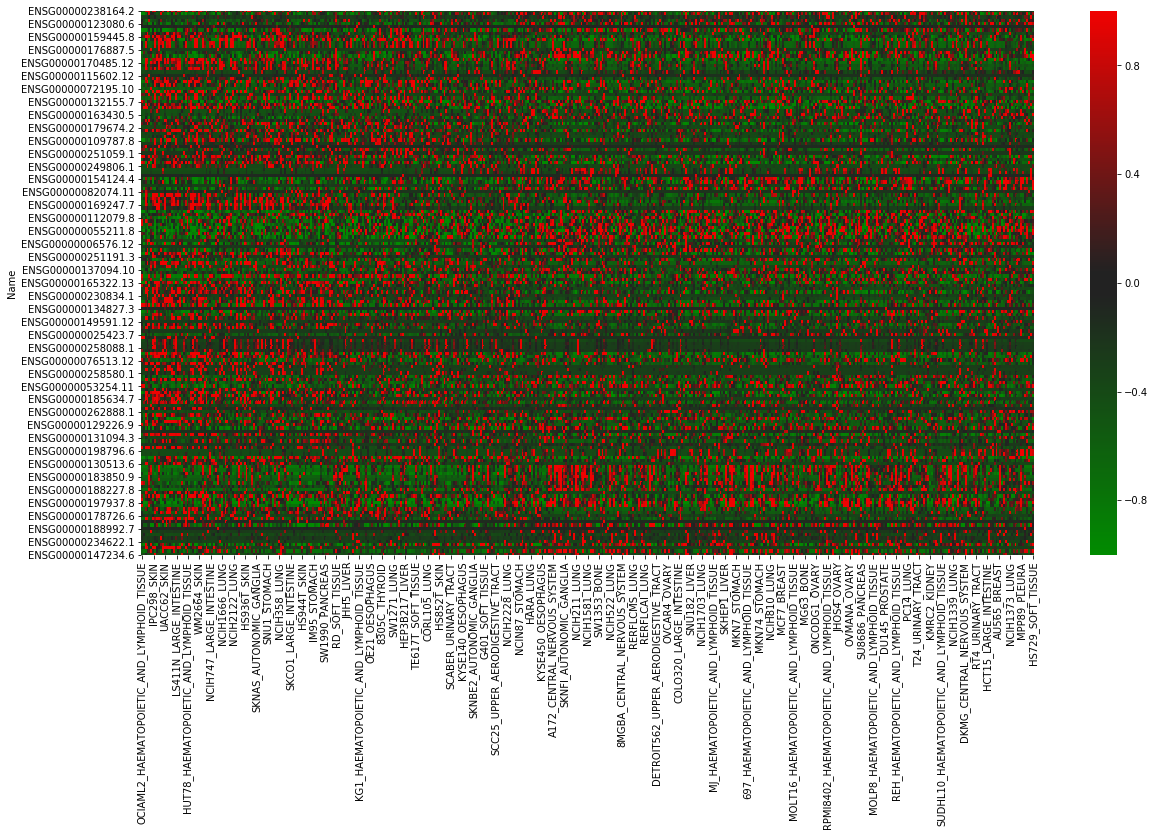

In [174]:
# samples sorted by increasing ic50 values *no color bar yet*
plt.figure(figsize = (20,10))
sns.heatmap(importance_RPKMData[list(ic50.sort_values(ascending=True).index)], cmap = cmap_gene, vmin = -1.0, vmax = 1.0)

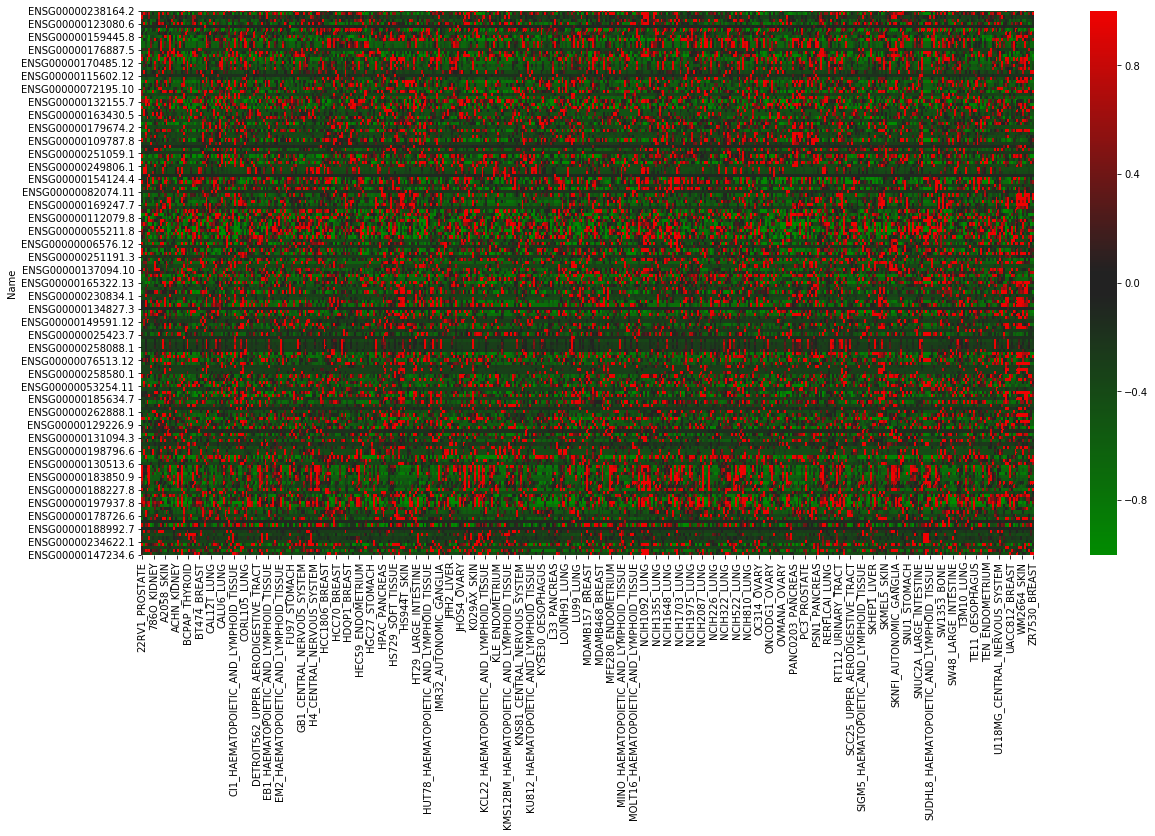

In [175]:
# samples grouped by tissue type
plt.figure(figsize = (20,10))
sns.heatmap(importance_RPKMData[list(filtered_withtype_RPKMData.loc["TumorType"].index)], cmap = cmap_gene, vmin = -1.0, vmax = 1.0)

In [182]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(pd.DataFrame(importance_RPKMData).to_numpy())
cluster_labels

array([ 5,  1,  0,  1,  0, 18,  1, 16, 17,  9, 12, 12,  0,  0,  0,  6, 15,
       15, 15, 16,  7,  1,  8,  8,  2,  6,  8,  8,  0, 16,  8,  2,  2,  4,
       18,  7,  7, 17,  7,  7,  8,  7,  6,  9,  7, 18, 11, 18, 16, 14, 14,
        1,  1,  1,  1,  1,  4,  8, 11, 11,  6,  6,  4,  7,  1,  4, 13, 13,
       13, 13,  1,  0,  1,  0,  0,  9, 17,  4,  9,  8,  0,  1,  8,  0,  8,
       18,  5, 17,  7, 17, 17, 17,  3,  2,  7, 17,  2,  6,  6,  1,  4, 18,
       19, 19, 19,  7,  9, 11,  4, 11,  5,  6, 17,  0, 17,  1,  0,  8,  6,
        3,  6,  8,  0, 17,  2,  6,  4,  6, 17,  4,  3, 11,  2,  8,  4,  5,
        2,  2,  8,  8, 17, 10, 10, 10, 10, 10,  0,  1, 10,  5, 11, 10, 10,
       10,  5,  8,  7,  6,  8,  1,  3,  0,  4,  4,  4,  0, 17,  0,  5],
      dtype=int64)

In [183]:
clustered_importance_RPKMData = importance_RPKMData
clustered_importance_RPKMData['CLUSTER_LABEL'] = cluster_labels
clustered_importance_RPKMData = clustered_importance_RPKMData.sort_values(by=['CLUSTER_LABEL'])
clustered_importance_RPKMData = clustered_importance_RPKMData.drop('CLUSTER_LABEL', 1)
importance_RPKMData = importance_RPKMData.drop('CLUSTER_LABEL', 1)
clustered_importance_RPKMData

,NCIH1915_LUNG,HS683_CENTRAL_NERVOUS_SYSTEM,WM2664_SKIN,KP2_PANCREAS,SNU423_LIVER,SW1417_LARGE_INTESTINE,SNU398_LIVER,COLO678_LARGE_INTESTINE,NCIH211_LUNG,BXPC3_PANCREAS,...,SKNDZ_AUTONOMIC_GANGLIA,HS936T_SKIN,A172_CENTRAL_NERVOUS_SYSTEM,TOV112D_OVARY,SNU387_LIVER,QGP1_PANCREAS,OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HPAC_PANCREAS,SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KP4_PANCREAS
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000176887.5,-0.297638,0.374477,-0.296638,-0.298242,-0.190092,-0.294539,-0.283777,-0.296759,-0.294370,-0.298342,...,7.216736,-0.298492,1.003679,1.477394,-0.297646,-0.298521,0.149755,-0.297916,-0.216760,-0.296923
ENSG00000242687.2,-0.536605,-0.079309,0.341824,-0.746676,-0.473293,-0.491519,-0.001775,0.038283,1.210681,-0.846532,...,2.375133,-0.533614,-0.833929,-0.183442,0.076664,2.477835,-0.082559,-0.516534,0.214353,2.014544
ENSG00000137094.10,0.393055,0.706278,-0.245953,-0.670998,0.552525,-0.725068,-0.261569,-0.644175,-0.848244,-0.545109,...,1.204846,-0.522103,-0.151812,1.694463,1.114276,-0.554746,-0.632695,-0.729751,0.249573,0.382050
ENSG00000259404.1,-0.000473,-0.360275,-0.239415,0.380502,-0.255703,-0.384622,-0.182390,-0.318234,-0.286377,-0.399151,...,2.750598,-0.321994,-0.244935,1.792505,-0.393698,-0.344587,-0.392176,-0.408012,0.455532,-0.412942
ENSG00000004777.14,-0.497978,0.054270,-0.057986,-0.570455,-0.259103,-0.480990,-0.215530,0.142689,1.098814,-0.989263,...,0.764116,-0.791606,0.026737,-0.363252,0.171730,0.290907,0.961179,-0.120230,0.458222,-0.387864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000152804.6,-0.019192,-0.507595,0.374809,0.230942,-0.082449,-0.326576,0.093561,-0.345780,-0.266140,0.065491,...,-0.471581,-0.310937,-0.510837,-0.180298,-0.057185,0.701016,-0.383514,1.063036,-0.385011,-0.174070
ENSG00000162391.7,-0.090387,-0.127038,-0.119338,-0.067557,-0.136004,0.007407,-0.076563,0.118501,-0.110978,0.016361,...,-0.031669,-0.102565,-0.073499,-0.062536,-0.113341,0.029706,-0.132058,-0.021878,-0.132516,-0.063415
ENSG00000258088.1,0.233189,-0.104960,-0.041806,0.041004,-0.149183,-0.242392,-0.299637,-0.296003,-0.304428,0.151643,...,-0.304428,-0.233137,-0.277163,-0.301333,-0.279920,-0.244693,-0.297114,-0.068437,-0.304428,-0.047519


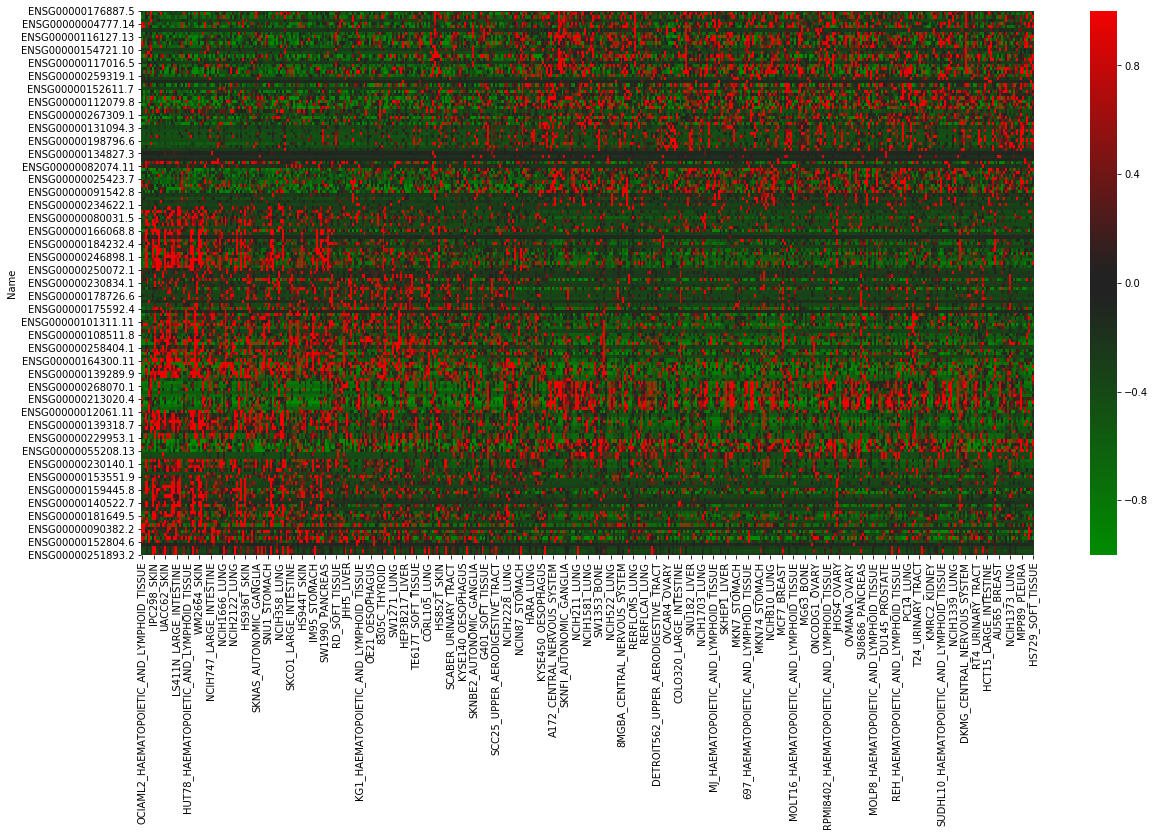

In [184]:
# samples sorted by increasing ic50 values WITH hierarchical clustering on the genes
plt.figure(figsize = (20,10))
sns.heatmap(clustered_importance_RPKMData[list(ic50.sort_values(ascending=True).index)], cmap = cmap_gene, vmin = -1.0, vmax = 1.0)